In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import wiener, gaussian, convolve2d
from scipy.fft import fft2, ifft2, fftshift
from skimage import io, img_as_ubyte, util, color
from skimage.metrics import peak_signal_noise_ratio

plt.style.use('dark_background')

In [31]:
def blur(img, kernel_size = 3):
    dummy = np.copy(img)
    h = np.eye(kernel_size) / kernel_size
    dummy = convolve2d(dummy, h, mode='same', boundary='fill', fillvalue=0)
    return dummy

In [32]:
def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h

def wiener_filter(img, kernel, K):
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = fft2(dummy)
    kernel = fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(ifft2(dummy))
    return dummy

In [33]:
original_image = io.imread('data/lena.jpg')
original_image = color.rgb2gray(original_image)
noisy_image = blur(original_image, kernel_size = 7) # util.random_noise(original_image, mode='gaussian')

scipy_image = wiener(noisy_image)
kernel = gaussian_kernel(5)
our_image = wiener_filter(noisy_image, kernel, K = 10)

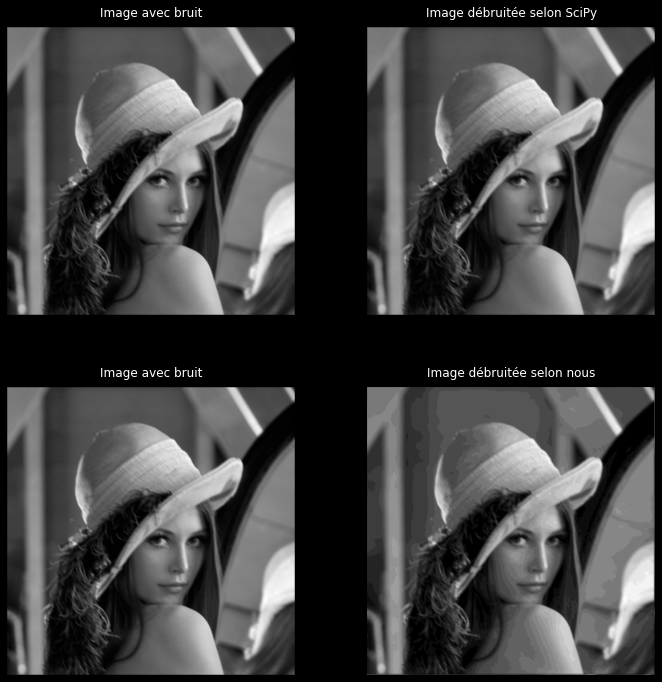

In [51]:
# Set the desired figure size (width, height) in inches
fig = plt.figure(figsize=(10, 10))

# Create a 2x2 grid of subplots
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

# Adjust the size of each subplot
ax1.imshow(noisy_image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Image avec bruit', fontsize=12, pad=10)
ax2.imshow(scipy_image, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Image débruitée selon SciPy', fontsize=12, pad=10)
ax3.imshow(noisy_image, cmap='gray')
ax3.set_axis_off()
ax3.set_title('Image avec bruit', fontsize=12, pad=10)
ax4.imshow(our_image, cmap='gray')
ax4.set_axis_off()
ax4.set_title('Image débruitée selon nous', fontsize=12, pad=10)

# Adjust the size of each subplot
ax1.set_position([0.05, 0.55, 0.4, 0.4])
ax2.set_position([0.55, 0.55, 0.4, 0.4])
ax3.set_position([0.05, 0.05, 0.4, 0.4])
ax4.set_position([0.55, 0.05, 0.4, 0.4])

# Show the figure
plt.show()

In [36]:
original_image = img_as_ubyte(original_image)
scipy_image = img_as_ubyte(scipy_image)
our_image = img_as_ubyte(our_image)

psnr_value_scipy = peak_signal_noise_ratio(original_image, scipy_image)
psnr_value_us = peak_signal_noise_ratio(original_image, our_image)
print("PSNR from SciPy:", psnr_value_scipy)
print("PSNR from us:", psnr_value_us)

PSNR from SciPy: 31.61590001645522
PSNR from us: 9.184620413111599
